In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import cv2
import mediapipe as mp
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [2]:
class GestureLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        """
        Initializes the LSTM model.
        :param input_size: Number of features per frame (e.g., 63 for 21 landmarks * 3 coordinates)
        :param hidden_size: Number of hidden units in the LSTM layers.
        :param num_layers: Number of LSTM layers.
        :param num_classes: Number of gesture classes.
        """
        super(GestureLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        """
        Forward pass of the model.
        :param x: Tensor of shape (batch_size, sequence_length, input_size)
        :return: Logits for each class.
        """
        # LSTM returns outputs for each time step and a hidden state tuple; we use the last time step.
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Select the output at the final time step.
        out = self.dropout(out)
        out = self.fc(out)
        return out


In [3]:
class GestureDataset(Dataset):
    def __init__(self, data_dir):
        """
        Initializes the dataset by scanning the provided directory for .npy files.
        Assumes filenames are formatted as "gestureLabel_index.npy".
        :param data_dir: Directory containing the processed .npy files.
        """
        self.file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".npy")]
        # Create a mapping from gesture labels to numeric indices.
        label_set = set()
        for f in self.file_paths:
            label = os.path.basename(f).split("_")[0]
            label_set.add(label)
        self.label2idx = {label: idx for idx, label in enumerate(sorted(label_set))}
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        """
        Loads a keypoint sequence and its label for a given index.
        :param idx: Index of the sample.
        :return: A tuple (sequence, label) where sequence is a tensor of shape (sequence_length, num_features)
                 and label is a tensor (numeric label).
        """
        file_path = self.file_paths[idx]
        sequence = np.load(file_path)  # Expected shape: (sequence_length, num_features)
        sequence = torch.tensor(sequence, dtype=torch.float32)
        label_str = os.path.basename(file_path).split("_")[0]
        label = self.label2idx[label_str]
        label = torch.tensor(label, dtype=torch.long)
        return sequence, label


In [4]:
def train_model(data_dir, num_epochs=50, batch_size=16, learning_rate=0.001,model_version="v1"):
    # Create the dataset from the processed data directory.
    dataset = GestureDataset(data_dir)
    
    # Split dataset into training and validation sets (80% train, 20% validation).
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    # Create DataLoaders for training and validation.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Determine input size (features per frame) from one sample.
    sample_seq, _ = dataset[0]
    input_size = sample_seq.shape[1]  # e.g., 63 (21 landmarks * 3 coordinates)
    num_classes = len(dataset.label2idx)
    
    # Initialize the GestureLSTM model.
    model = GestureLSTM(input_size=input_size, hidden_size=64, num_layers=2, num_classes=num_classes)
    
    # Use GPU if available.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Define the loss function and optimizer.
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    print(f"Training on {device} with {len(train_dataset)} training samples and {len(val_dataset)} validation samples.")
    
    best_val_loss = float('inf')
    
    # Prepare CSV logging.
    log_file = os.path.join("..", "logs", "training_log.csv")
    with open(log_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])
    
    # Training loop.
    for epoch in range(1, num_epochs + 1):
        model.train()  # Set model to training mode.
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training phase.
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * sequences.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / total
        train_acc = (correct / total) * 100
        
        # Validation phase.
        model.eval()  # Set model to evaluation mode.
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * sequences.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss /= total_val
        val_acc = (correct_val / total_val) * 100
        
        print(f"Epoch [{epoch}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Append metrics to CSV log.
        with open(log_file, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc])
        
        # Save the model checkpoint if validation loss improves.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            os.makedirs(os.path.join("..","models"), exist_ok=True)
            checkpoint_path = os.path.join("..","models", "gesture_model.pt")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Model improved. Saved checkpoint to {checkpoint_path}")
    
    print("Training complete.")


In [5]:
DATA_DIR = os.path.join("..", "data", "processed")
train_model(DATA_DIR)

Training on cuda with 360 training samples and 90 validation samples.
Epoch [1/50] - Train Loss: 1.0637, Train Acc: 42.78% | Val Loss: 0.9718, Val Acc: 42.22%
Model improved. Saved checkpoint to ..\models\gesture_model.pt
Epoch [2/50] - Train Loss: 0.8851, Train Acc: 58.89% | Val Loss: 0.7348, Val Acc: 73.33%
Model improved. Saved checkpoint to ..\models\gesture_model.pt
Epoch [3/50] - Train Loss: 0.7485, Train Acc: 67.50% | Val Loss: 0.5976, Val Acc: 81.11%
Model improved. Saved checkpoint to ..\models\gesture_model.pt
Epoch [4/50] - Train Loss: 0.6129, Train Acc: 73.89% | Val Loss: 0.5094, Val Acc: 83.33%
Model improved. Saved checkpoint to ..\models\gesture_model.pt
Epoch [5/50] - Train Loss: 0.4956, Train Acc: 81.11% | Val Loss: 0.4300, Val Acc: 86.67%
Model improved. Saved checkpoint to ..\models\gesture_model.pt
Epoch [6/50] - Train Loss: 0.4607, Train Acc: 82.78% | Val Loss: 0.5363, Val Acc: 77.78%
Epoch [7/50] - Train Loss: 0.4735, Train Acc: 82.22% | Val Loss: 0.5772, Val Acc:

In [6]:
log_file = os.path.join("..","logs","training_log.csv") # Adjust path if needed
df = pd.read_csv(log_file)

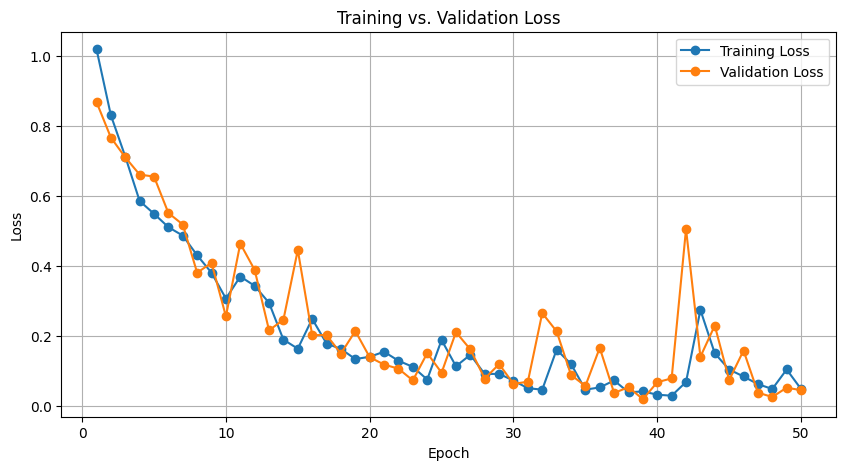

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_loss'], label='Training Loss', marker='o')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join("..","graphs","loss_curve.png"))
plt.show()

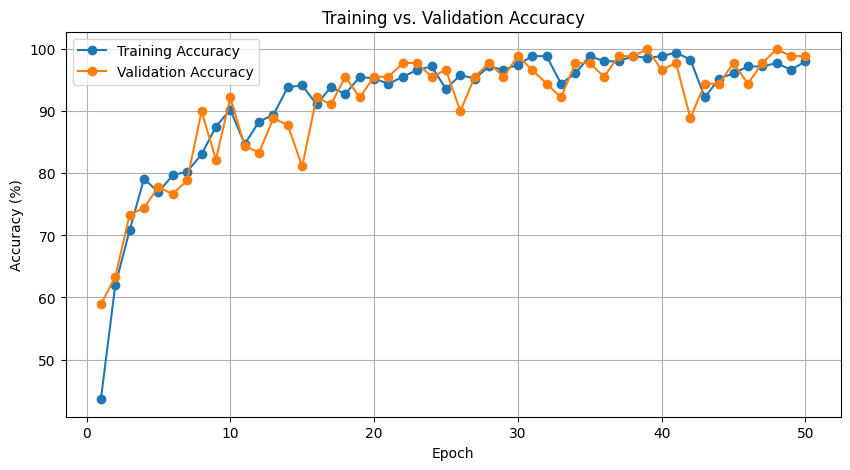

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_acc'], label='Training Accuracy', marker='o')
plt.plot(df['epoch'], df['val_acc'], label='Validation Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join("..","graphs","accuracy_curve.png"))
plt.show()

In [9]:
def extract_keypoints(frame, hands):
    """
    Extracts hand keypoints from a frame using MediaPipe.
    Returns a flattened NumPy array of keypoints (x, y, z for each landmark) or None if no hand is detected.
    """
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)
    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0]
        keypoints = []
        for lm in landmarks.landmark:
            keypoints.extend([lm.x, lm.y, lm.z])
        return np.array(keypoints)
    return None

In [10]:
label_map = {1: 'hello', 0: 'bye', 2: 'thankyou'}
input_size = 63
num_classes = len(label_map)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [12]:
model = GestureLSTM(input_size=input_size, hidden_size=64, num_layers=2, num_classes=num_classes)
model_path = os.path.join("..", "models", "gesture_model.pt")
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

GestureLSTM(
  (lstm): LSTM(63, 64, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)

In [13]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.7)


In [14]:
cap = cv2.VideoCapture(0)
sequence = []              # Buffer to hold keypoint sequences
sequence_length = 30 

In [15]:
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Optional: flip the frame horizontally for a mirror view
    frame = cv2.flip(frame, 1)

    # Extract keypoints from current frame
    keypoints = extract_keypoints(frame, hands)
    if keypoints is not None:
        sequence.append(keypoints)
        if len(sequence) > sequence_length:
            sequence.pop(0)  # Maintain a fixed-length buffer

    # When we have enough frames, perform inference
    if len(sequence) == sequence_length:
        input_seq = np.array(sequence)  # Shape: (sequence_length, input_size)
        # Convert to tensor, add batch dimension, and move to GPU
        input_seq = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_seq)
            predicted_idx = torch.argmax(output, dim=1).item()
            gesture_name = label_map[predicted_idx]
        cv2.putText(frame, f"Gesture: {gesture_name}", (10, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow("Real-Time Gesture Recognition", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
hands.close()